# [Computational Social Science] Project 4: Unsupervised Learning

Group Number:

Group Members: Rachel Pizatella-Haswell

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [87]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [ ]:
#import keras

In [88]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

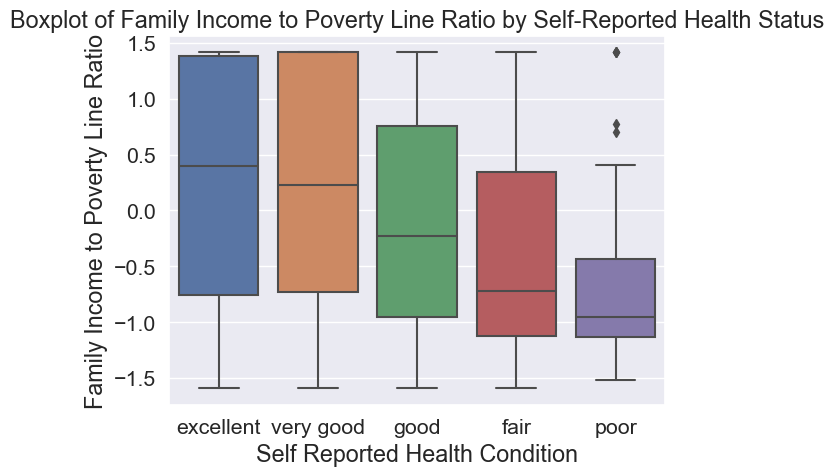

In [89]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

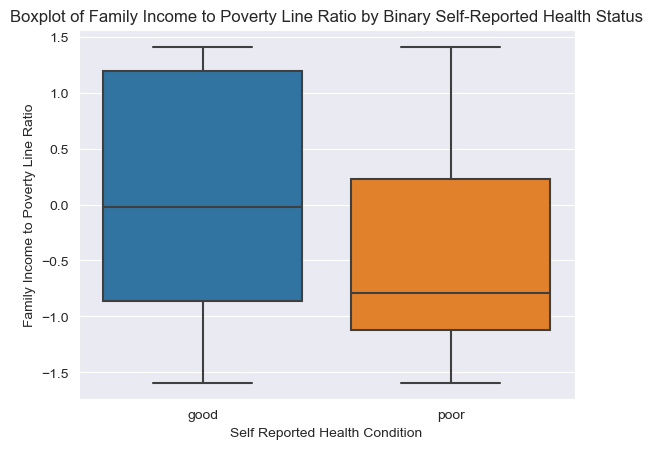

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

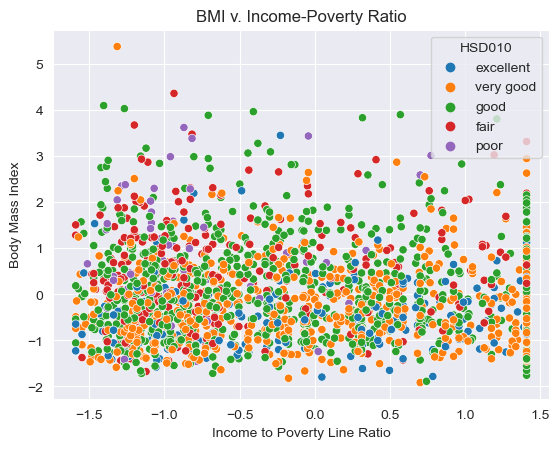

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
y_binary = nhanes_scaled['HSD010_binary']
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [145]:
pca = PCA(n_components=10)
pca_nhanes = pca.fit_transform(nhanes_scaled)

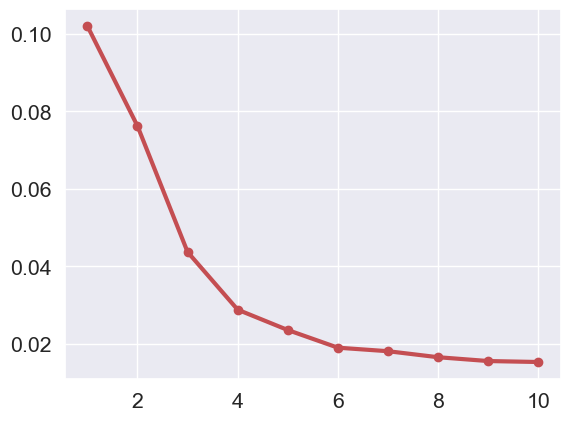

In [146]:
pca_component_values = np.arange(pca.n_components_) + 1
plt.plot(pca_component_values, pca.explained_variance_ratio_, 'ro-', linewidth = 3)

It looks like 5 principal components is about the right tradeoff in terms of reducing variance not overcomplicating the model.

In [147]:
pca = PCA(n_components=5)
pca_nhanes = pca.fit_transform(nhanes_scaled)

In [148]:
pca_df = pd.DataFrame(data = pca_nhanes
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 
                          'principal component 4', 'principal component 5'])

In [149]:
pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,9.527811,-0.816225,-1.867074,-2.109652,-3.929909
1,-5.838339,-3.692572,3.805730,-1.029869,0.392712
2,-0.719454,-2.573202,0.907969,-4.754973,-1.801890
3,3.533627,-2.576979,-3.249240,-0.406894,3.999104
4,-6.872094,-4.194241,0.886846,-0.848682,-0.527448


In [13]:
variance = pca.explained_variance_ratio_
variance

array([0.10201961, 0.07623011, 0.04371192, 0.02882171, 0.02357117])

In [14]:
names = ['Component 1', 'Component 2','Component 3', 'Component 4', 'Component 5']

### Barplot of Components

Text(0.5, 1.0, 'PCA: Explained Variance by Component')

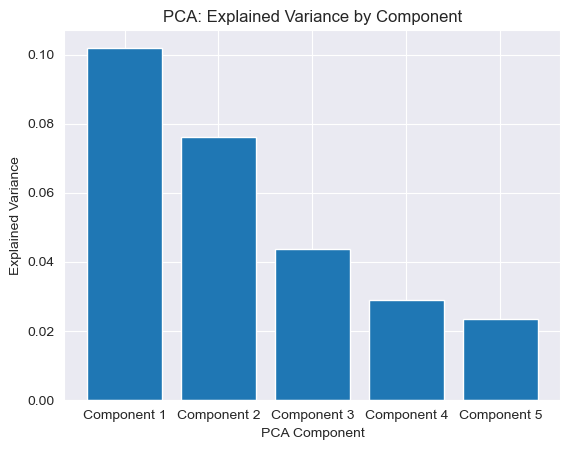

In [15]:
plt.bar(names, variance)
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance')
plt.title('PCA: Explained Variance by Component')

### How many components will you use to fit a supervised learning model?

In [16]:
#Perform Test-Train Split
X = pca_df
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, train_size = .80, test_size=0.20, random_state=10)

In [17]:
# create a model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
logit_reg = LogisticRegression(max_iter= 5000) 

# fit the model
logit_model = logit_reg.fit(X_train, y_train)

y_pred = logit_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

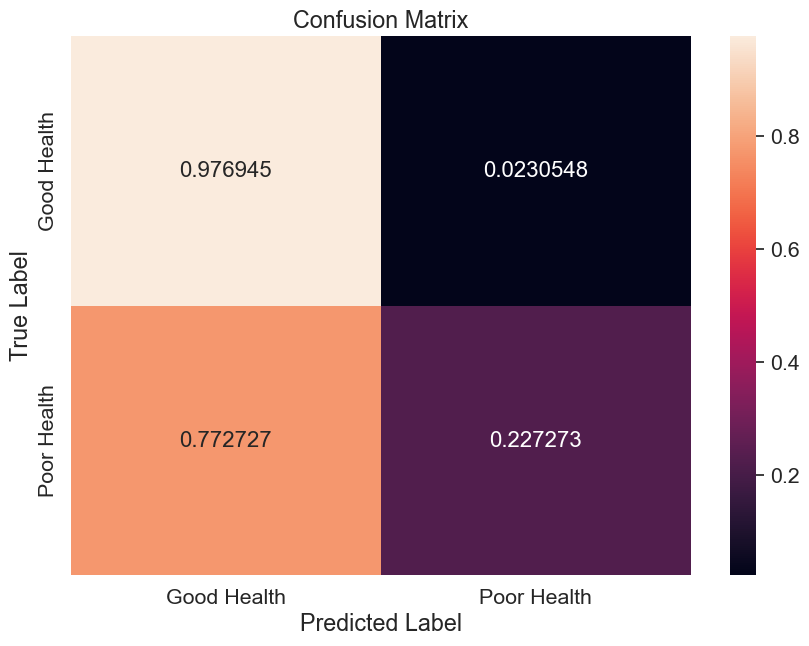

In [18]:
df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Good Health", 1: "Poor Health"})
df_cm.index = ["Good Health", "Poor Health"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [19]:
#Repeat for regular features supervised ML model
#Perform Test-Train Split
X = nhanes_scaled
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, train_size = .80, test_size=0.20, random_state=10)

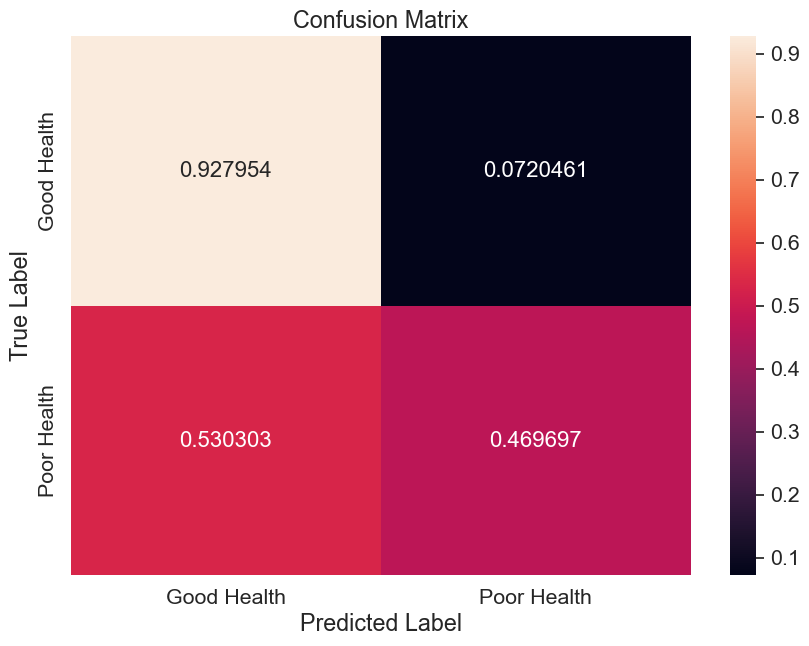

In [20]:
# create a model
logit_reg = LogisticRegression(max_iter= 5000) 

# fit the model
logit_model = logit_reg.fit(X_train, y_train)

y_pred = logit_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

#Create confusion matrix
df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Good Health", 1: "Poor Health"})
df_cm.index = ["Good Health", "Poor Health"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 2D Scatterplot of the first two components

Text(0.5, 1.0, 'Scatterplot: 1st and 2nd Componenets')

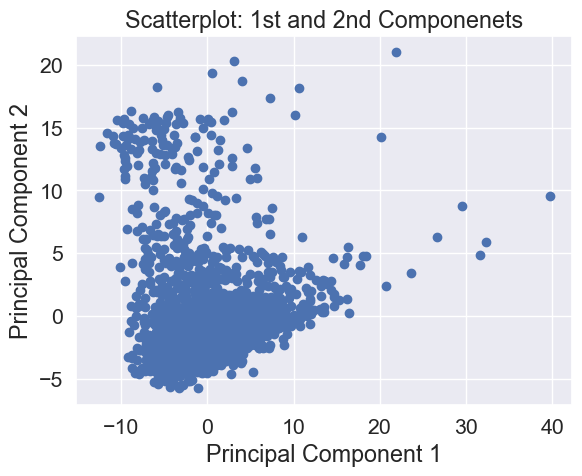

In [21]:
plt.scatter(pca_df['principal component 1'], pca_df['principal component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot: 1st and 2nd Componenets')

It looks like there are a few outliers that are creating more variance along the first principal component and that there might be more variation other than the outliers along the second component. Moreover, it looks like there might be two main clusters that primarily differ in their values on the second principal component. 

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm
I will use the k-means clustering algorithm. This algorithm creates a pre-specified number of clusters (k) by sorting observations into clusters in order to minimize within-cluster variation summed across all clusters. I will use the elbow method to deterimine the number of clusters. This involves visually checking the tradeoff between reducing the unexplained variance in the dataset and introucing more clusters.

In [28]:
#Use elbow method
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "random_state": 1,
}

In [30]:
sum_of_squared_errors = [] 
for k in range(1,10):
    kmeans =KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(nhanes_scaled)
    sum_of_squared_errors.append(kmeans.inertia_)

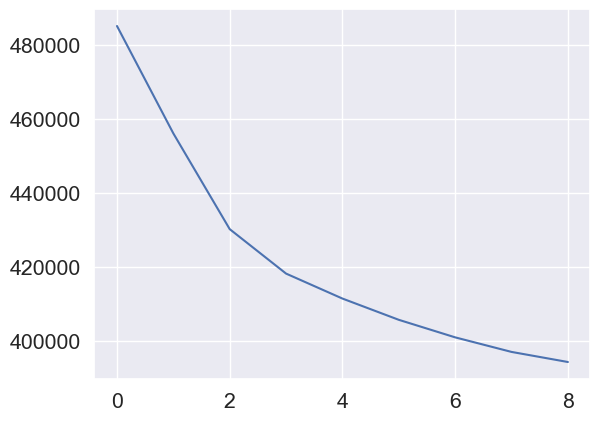

In [32]:
plt.plot(sum_of_squared_errors)

### Cluster nhanes

In [33]:
np.random.seed(1234)
X = nhanes_scaled
kmeans = KMeans(n_clusters=3).fit(X)

/Users/saa0726/opt/anaconda3/envs/CSS2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [34]:
for col in X.columns:
    print(col)

DR1DRSTZ
DR1EXMER
DRABF
DRDINT
DR1DBIH
DR1DAY
DR1LANG
DR1MNRSP
DR1HELPD
DBQ095Z
DRQSPREP
DR1STY
DRQSDIET
DR1TNUMF
DR1TKCAL
DR1TPROT
DR1TCARB
DR1TSUGR
DR1TFIBE
DR1TTFAT
DR1TSFAT
DR1TMFAT
DR1TPFAT
DR1TCHOL
DR1TATOC
DR1TRET
DR1TVARA
DR1TBCAR
DR1TLZ
DR1TVB1
DR1TVB2
DR1TNIAC
DR1TVB6
DR1TFOLA
DR1TFA
DR1TFF
DR1TFDFE
DR1TCHL
DR1TVB12
DR1TVC
DR1TVD
DR1TVK
DR1TCALC
DR1TPHOS
DR1TMAGN
DR1TIRON
DR1TZINC
DR1TCOPP
DR1TSODI
DR1TPOTA
DR1TSELE
DR1TMOIS
DR1TS040
DR1TS060
DR1TS080
DR1TS100
DR1TS120
DR1TS140
DR1TS160
DR1TS180
DR1TM161
DR1TM181
DR1TM201
DR1TP182
DR1TP183
DR1TP204
DR1.300
DR1TWS
DRD340
DRD360
PEASCST1
PEASCTM1
BPXPULS
BMDSTATS
BMXWT
BMXHT
BMXBMI
BMXARML
BMXARMC
BMXWAIST
MGDEXSTS
OHDEXSTS
OHDDESTS
OHX01TC
OHX02TC
OHX03TC
OHX04TC
OHX05TC
OHX06TC
OHX07TC
OHX08TC
OHX09TC
OHX10TC
OHX11TC
OHX12TC
OHX13TC
OHX14TC
OHX15TC
OHX16TC
OHX17TC
OHX18TC
OHX19TC
OHX20TC
OHX21TC
OHX22TC
OHX23TC
OHX24TC
OHX25TC
OHX26TC
OHX27TC
OHX28TC
OHX29TC
OHX30TC
OHX31TC
OHX32TC
URXUMA
URXUMS
URXUCR.x
URXCRS
URDACT
LBXWBCS

<Axes: xlabel='BMXBMI', ylabel='INDFMPIR'>

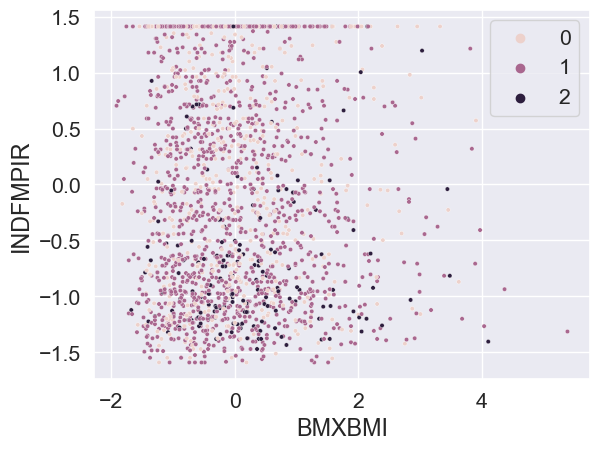

In [41]:
sns.scatterplot(
    x = X['BMXBMI'], y = X['INDFMPIR'], hue = kmeans.labels_, s = 10
)


It's really difficult to see any discernable pattern here or any particular relationship between BMI and the poverty ratio.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [48]:
## Your Answer Here
kmeans_pca = KMeans(n_clusters=3).fit(pca_df)

/Users/saa0726/opt/anaconda3/envs/CSS2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: xlabel='BMXBMI', ylabel='INDFMPIR'>

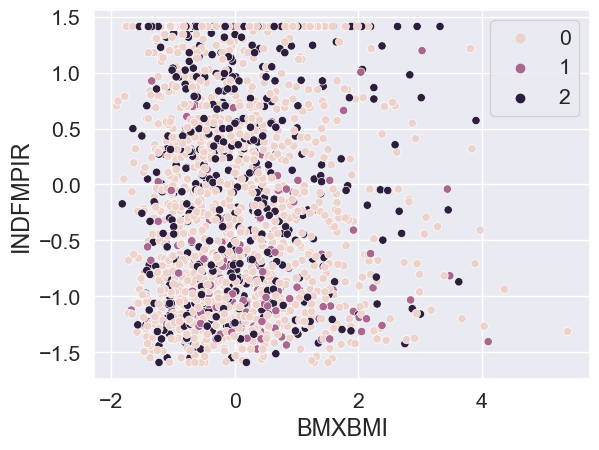

In [49]:
sns.scatterplot(
    x = X['BMXBMI'], y = X['INDFMPIR'], hue = kmeans_pca.labels_
)

<Axes: xlabel='BMXBMI', ylabel='INDFMPIR'>

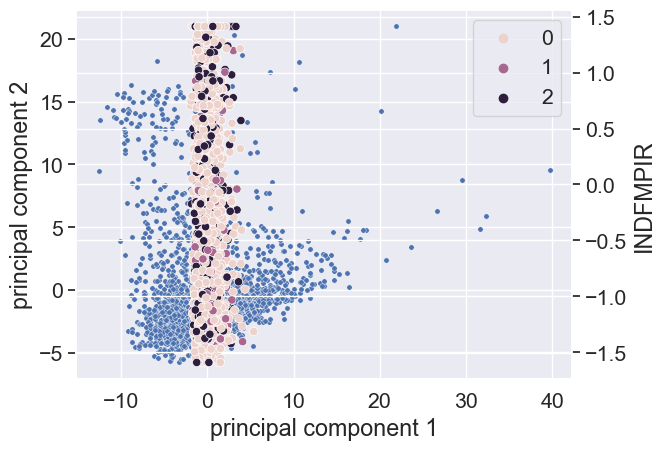

In [50]:
fig, ax = plt.subplots()
sns.scatterplot(
    x= pca_df['principal component 1'], y = pca_df['principal component 2'], s = 15
)
ax2 = ax.twinx()
sns.scatterplot(
    x = X['BMXBMI'], y = X['INDFMPIR'], hue = kmeans_pca.labels_
)

I'm not sure that I am doing this correctly because it does not make sense to plot the clusters on top of the 2d pca scatterplot as the axis scales are different.

In [52]:
#Try plotting centroids of the clusters instead
print(kmeans_pca.cluster_centers_)

[[-1.93797575 -1.56697231  0.1197443   0.18778468  0.10008805]
 [-4.13700858 11.44304159 -1.44487694 -1.89237294 -0.04131934]
 [ 6.01441976  0.29217039  0.1539868   0.1260378  -0.23180737]]


<Axes: >

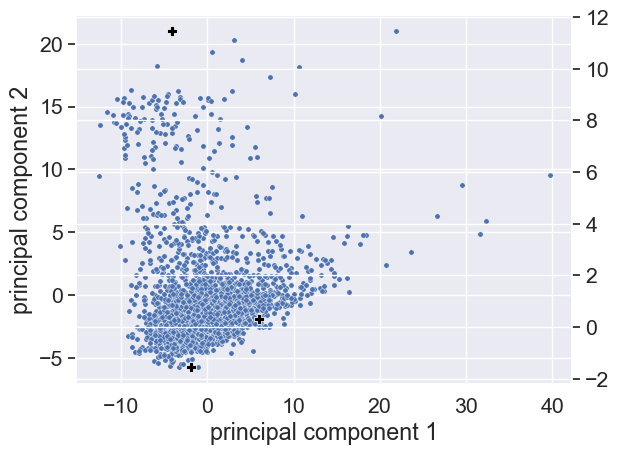

In [64]:
fig, ax = plt.subplots()
sns.scatterplot(
    x= pca_df['principal component 1'], y = pca_df['principal component 2'], s = 15
)
ax2 = ax.twinx()
sns.scatterplot(x = kmeans_pca.cluster_centers_[:,0], y =kmeans_pca.cluster_centers_[:,1],
                marker = 'P', color = 'black', s = 50)

This seems wrong as well. 

## I cannot get the Neural Network to work because I cannot import keras

Every time I try to import keras to do the neural network part of this analysis I get the following message: "The kernel appears to have died. It will restart automatically." I have tried everything to fix this and have run out of time. I've created multiple new virtual environments, uninstalled and re-installed every package and tried to implement the fixes suggested by dozens of stack overflow threads and nothing has worked. 

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### I'm going to use a penalized logit for classifcation since I can't import Keras

In [90]:
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010,HSD010_binary
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,excellent,good
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,excellent,good
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,very good,good
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,very good,good
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,good,good


In [91]:
y = nhanes_scaled['HSD010_binary']
nhanes_scaled = nhanes_scaled.drop(['HSD010_binary', 'HSD010'], axis = 1)


In [ ]:
#nhanes_scaled = pd.get_dummies(nhanes_scaled, columns =[''])

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [122]:
np.random.seed(1234)
#y = nhanes_scaled['HSD010_binary']
X = nhanes_scaled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [100]:
X_test.shape

(516, 241)

In [123]:
logit_cv = LogisticRegressionCV(cv=5, random_state=0, max_iter=10000)
logit_cv.fit(X_train, y_train)

LogisticRegressionCV(cv=5, max_iter=10000, random_state=0)

In [124]:
preds = logit_cv.predict(X_test)

In [125]:
accuracy_score(y_test, preds)

0.874031007751938

In [150]:
#Now redo on the principal components
pca_df.shape

(2064, 5)

In [151]:
np.random.seed(1234)
#y = nhanes_scaled['HSD010_binary']
X = pca_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)
logit_cv = LogisticRegressionCV(cv=5, random_state=0, max_iter=10000)
logit_cv.fit(X_train, y_train)
preds = logit_cv.predict(X_test)

In [152]:
accuracy_score(y_test, preds)

0.8624031007751938

In [154]:
#And finally repeat for the PCA compnents and predicted class membership
pca_cluster_df = pca_df.copy()
pca_cluster_df['kmeans_class'] = kmeans_pca.labels_

In [155]:
pca_cluster_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,kmeans_class
0,9.527811,-0.816225,-1.867074,-2.109652,-3.929909,2
1,-5.838339,-3.692572,3.805730,-1.029869,0.392712,0
2,-0.719454,-2.573202,0.907969,-4.754973,-1.801890,0
3,3.533627,-2.576979,-3.249240,-0.406894,3.999104,2
4,-6.872094,-4.194241,0.886846,-0.848682,-0.527448,0


In [156]:
np.random.seed(4321)
#y = nhanes_scaled['HSD010_binary']
X = pca_cluster_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)
logit_cv = LogisticRegressionCV(cv=5, random_state=0, max_iter=10000)
logit_cv.fit(X_train, y_train)
preds = logit_cv.predict(X_test)

In [158]:
accuracy_score(y_test, preds) #Looks the exact same, which is a little odd but I can't seem to get it to change

0.8624031007751938

The classfier that use only the 5 PCA components (and the classfier using PCA components + predicted cluster) did nearly as well in terms of accuracy score as the classifier that used the 200+ original features.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

While both PCA and clustering seek to simplify a dataset, they perform very different functions. Clustering is looking for patterns among the data in order to identify groups of observations that are most similar to one another in order to minimize total within cluster variance. This is useful for learning about the structure of the dataset and uncovering relationships that may be useful for future analysis. PCA on the other hand seeks to explain as much of the variation in a dataset as possible through a pre-specified number of orthogonal linear combinations of features of the data. In doing so PCA can help capture most of the information in a dataset with a relatively small number of features (compoennts).

PCA, like clustering, is seeking to explain variation in a dataset, but it does not explicitly group observations together.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

I didn't see any advantages but my analysis looked a little odd when I was doing both. In terms of dimensionality reduction before using a supervised ML method, it does not seem necessary to use two methods. It may be that in certain situations, adding cluster predictions to the PCA will add information that a classifier can use to be more accurate. In this situation, using the two together may not have done much since 5 PCA compnents already captured most of the information in the dataset or the kmeans clustering was not a sophisticated enough algorithm to add any information about the dataset that the PCA analysis didn't capture. 

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques can drastically simplify a dataset without losing the important variation that a dataset contains. This is especially helpful when you have a very large dataset with more features than is practical to comb through manually. Reducing the dimensionality of a dataset through tools such as PCA also serves as a dimensionality reduction mechanism that doesn't introduce extra researcher degrees of freedom that may bias the results of analysis (similar to regularization). 

Clustering is particularly useful because it allows researchers to unconver important patterns and subgroups within a dataset that you might otherwise miss. Similar to PCA, the unsupervised nature of clustering means that there is less leeway for a researcher to introduce bias and only focus on patterns that they anticipate ex ante. 